In [88]:
import wfdb 
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.signal as signal
import scipy.stats as stats

4
100
(2979796, 4)
['Resp C', 'Resp A', 'Resp N', 'SpO2']


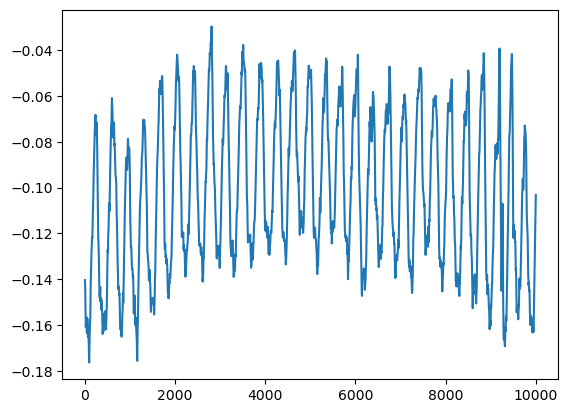

In [89]:
data_loc = "data/apnea_ecg/"

# Load the apnea-ecg dataset
# https://physionet.org/content/apnea-ecg/1.0.0/

record = wfdb.rdrecord(data_loc + 'a04r')
annotation = wfdb.rdann(data_loc + 'a04r', 'apn')


# check how many channels there are
print(record.n_sig)

# check the sampling frequency
print(record.fs)

# check the length of the recording
print(record.p_signal.shape)

# check the names of the channels
print(record.sig_name)


# plot resp C from 0 to 1000
plt.plot(record.p_signal[0:10000, 0])
plt.show()


In [90]:
len(annotation.symbol)

492

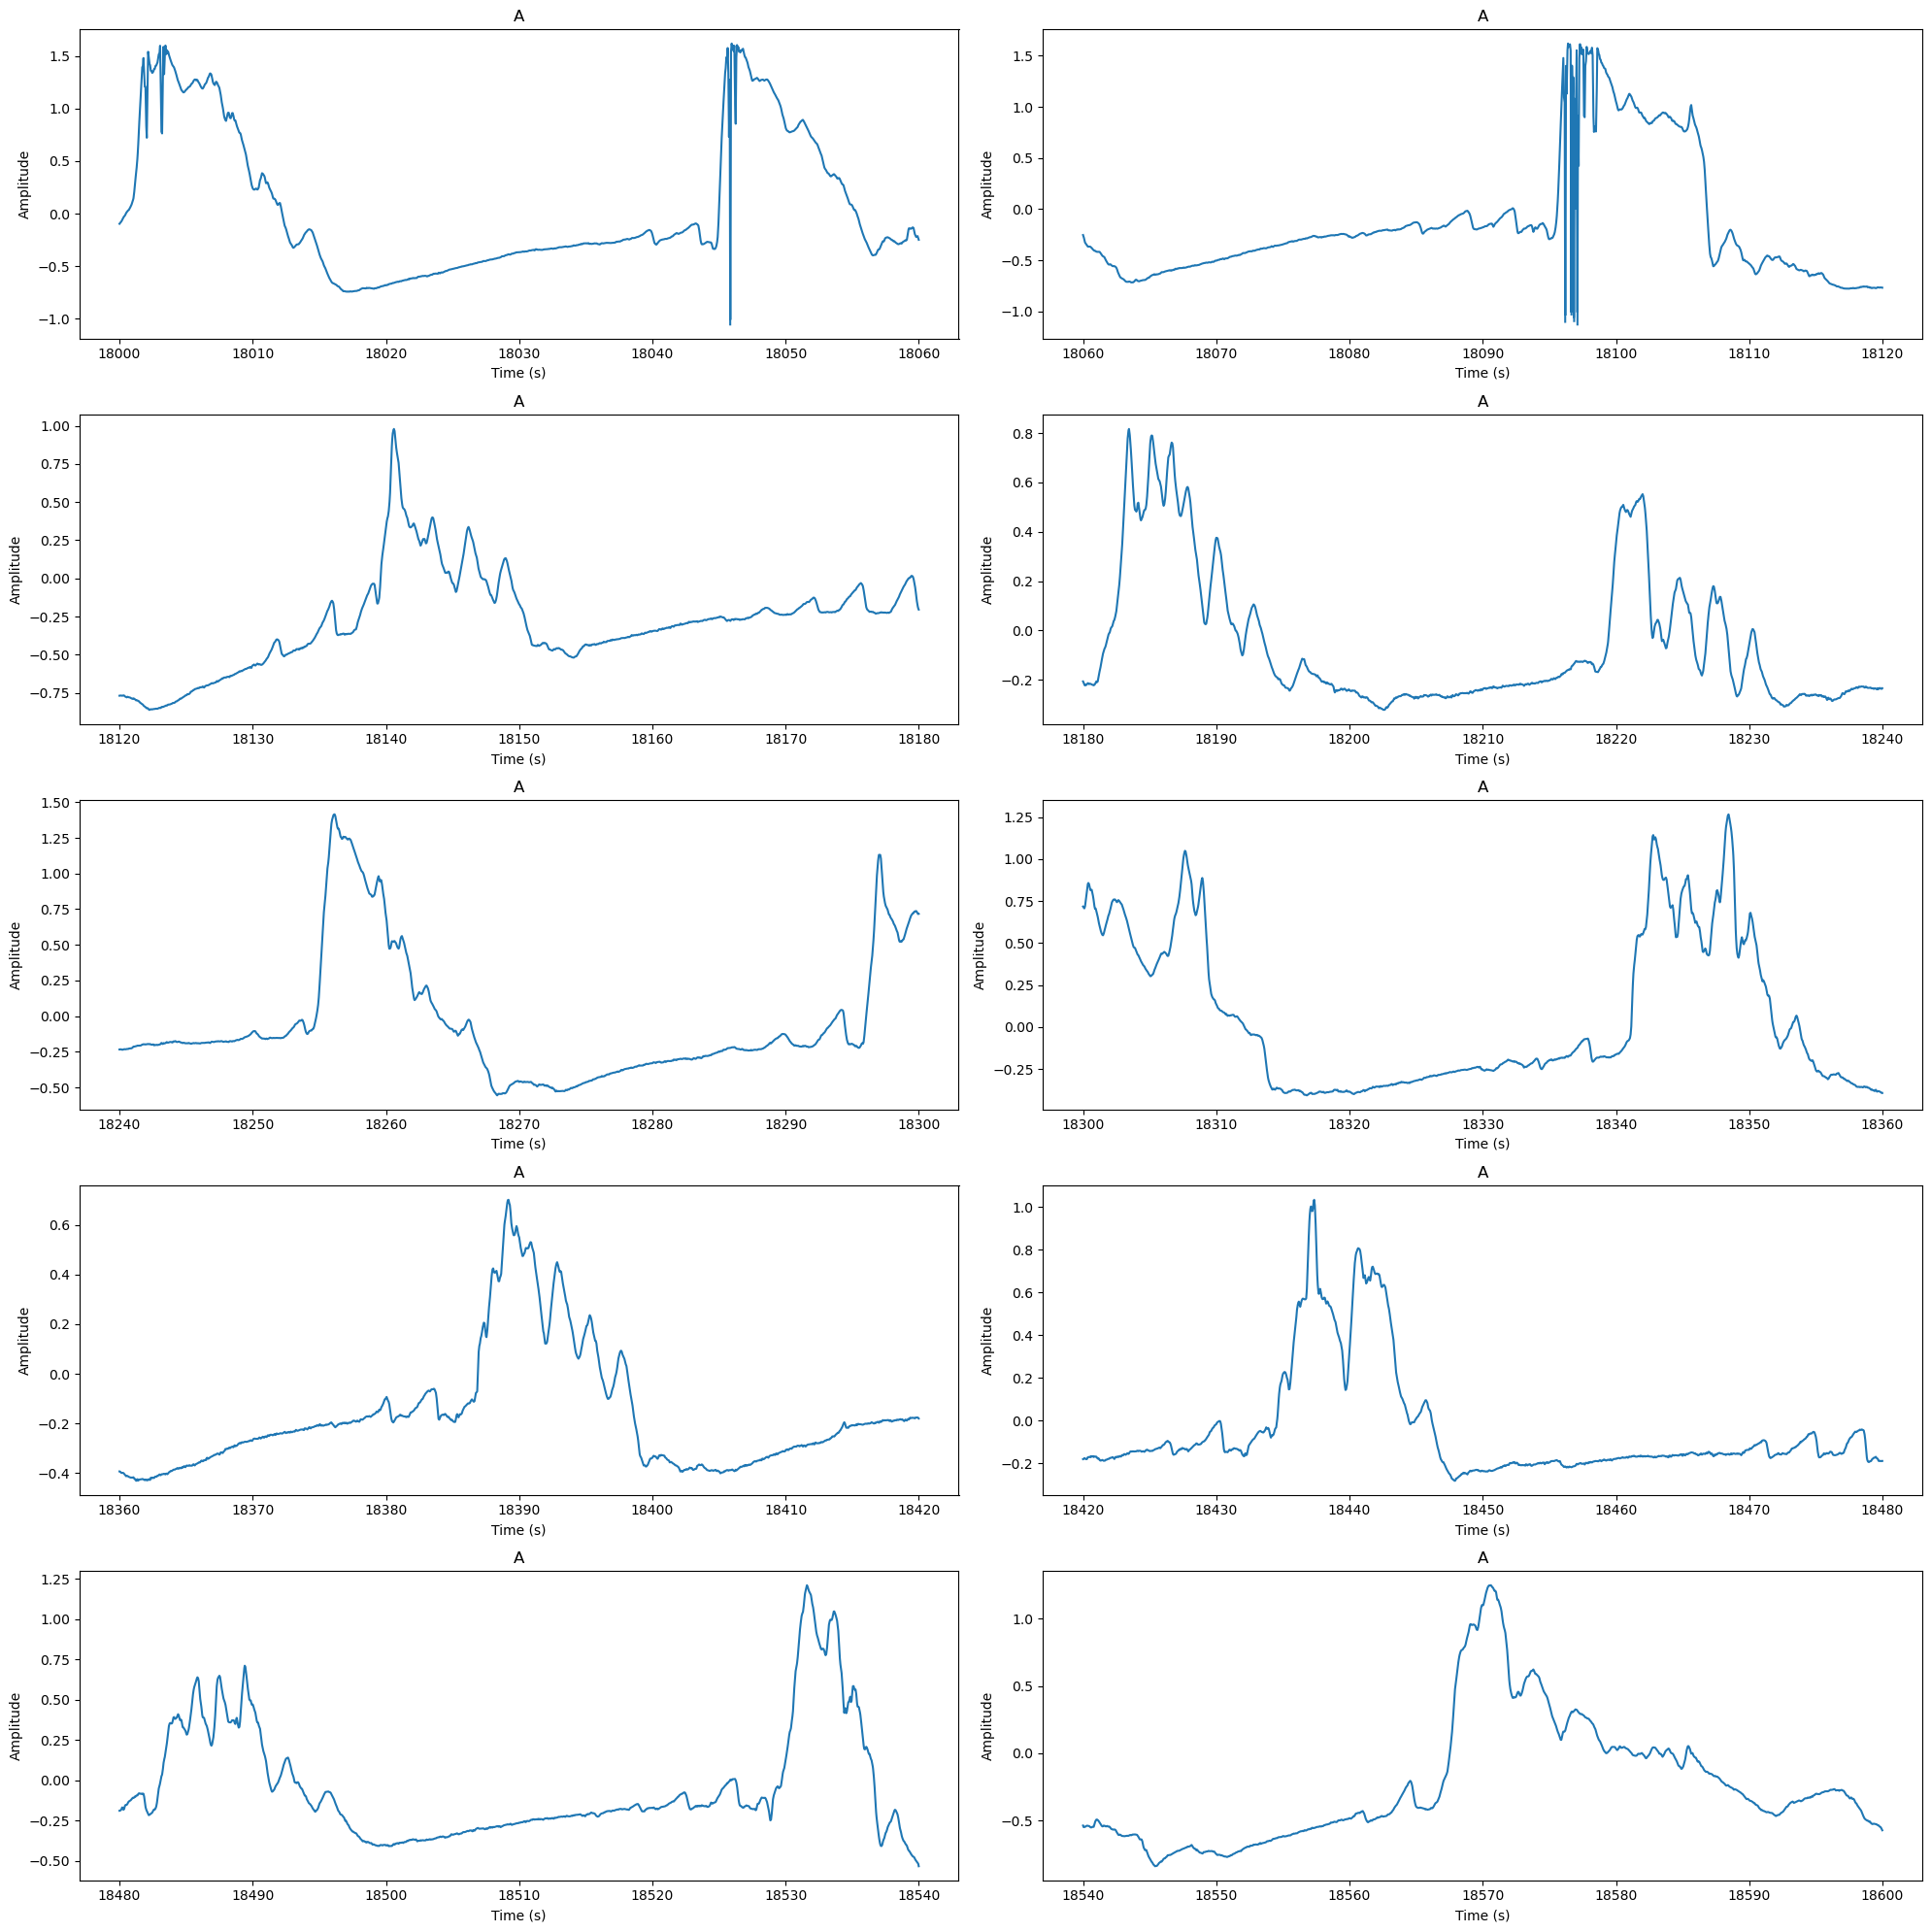

In [91]:
import math

# Calculate the number of subplots needed
num_intervals = 10

# Create subplots
fig, axs = plt.subplots(5, 2, figsize=(20, 20))

starting = 300
# Iterate over each interval
for i in range(num_intervals):
    start_index = (i+starting) * record.fs * 60
    end_index = (i +starting+1) * record.fs * 60
    
    # Calculate the subplot position
    row = i // 2
    col = i % 2
    
    # Plot the interval
    axs[row, col].plot(np.arange(start_index, end_index) / record.fs, record.p_signal[start_index:end_index, 0])
    axs[row, col].set_xlabel('Time (s)')
    axs[row, col].set_ylabel('Amplitude')
    
    # Set the annotation as the title
    annotation_title = annotation.symbol[(i+starting)]
    axs[row, col].set_title(annotation_title)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [92]:
from collections import Counter

# Count the frequency of classes in annotation.symbol
annotation_counts = Counter(annotation.symbol)

# Print the counts
print(annotation_counts)


Counter({'A': 453, 'N': 39})


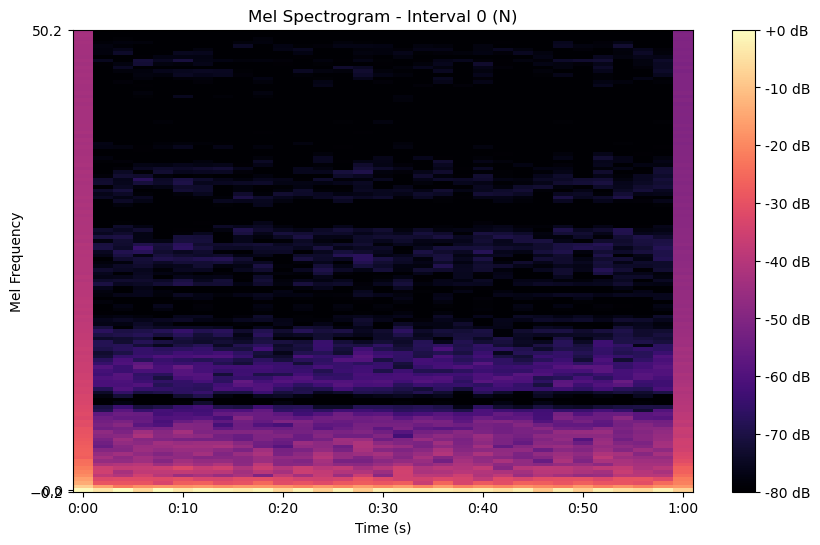

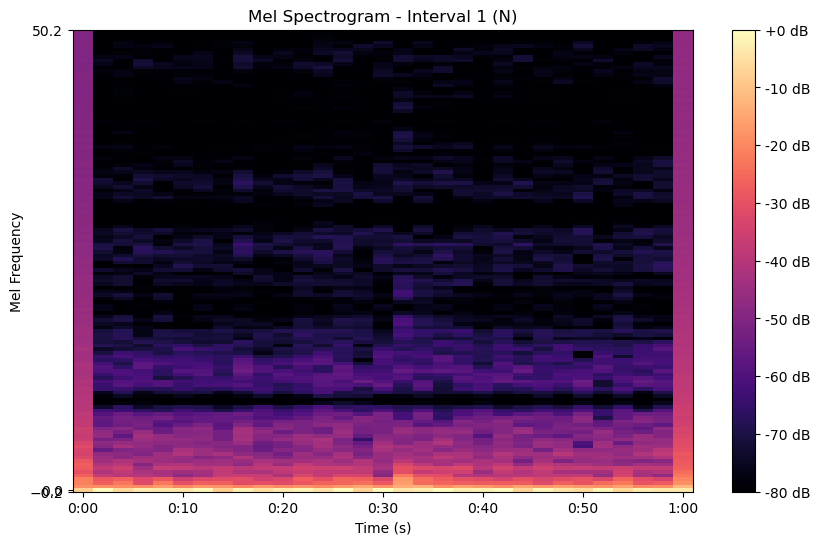

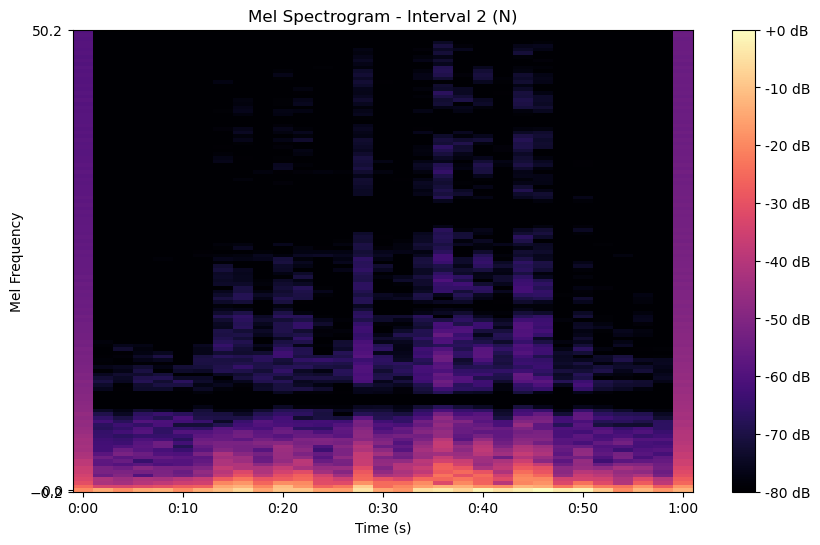

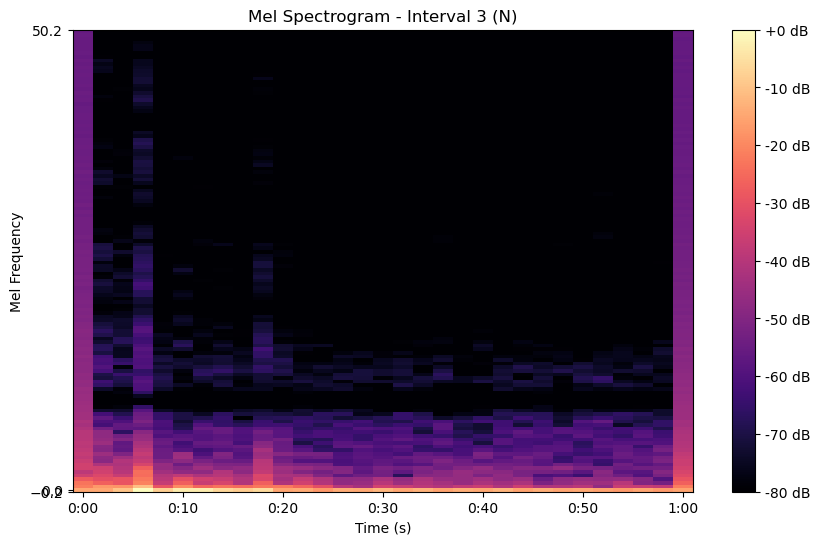

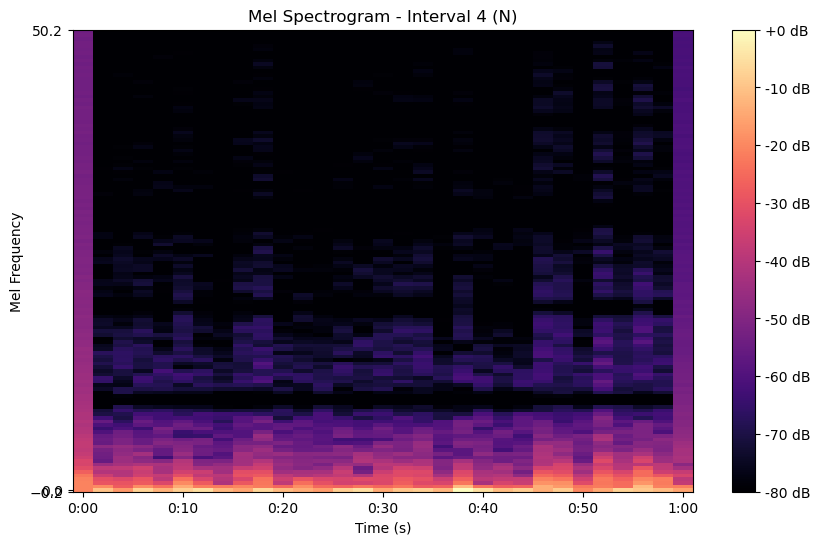

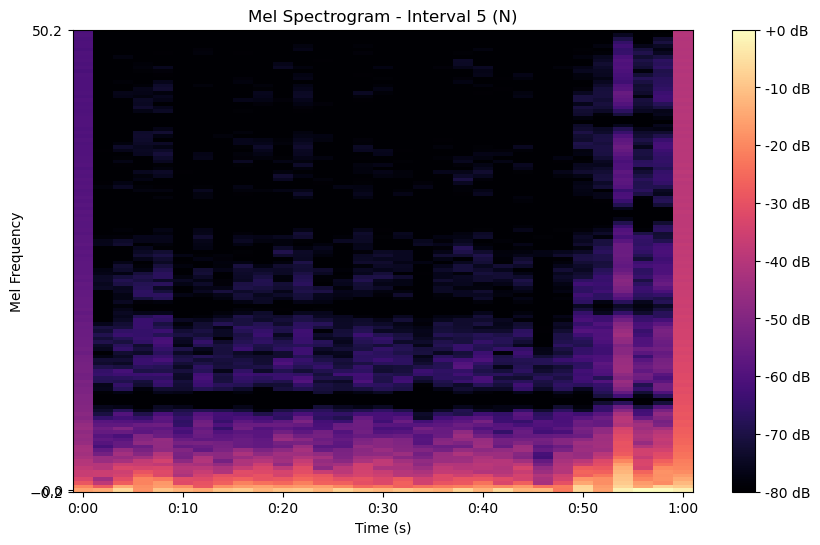

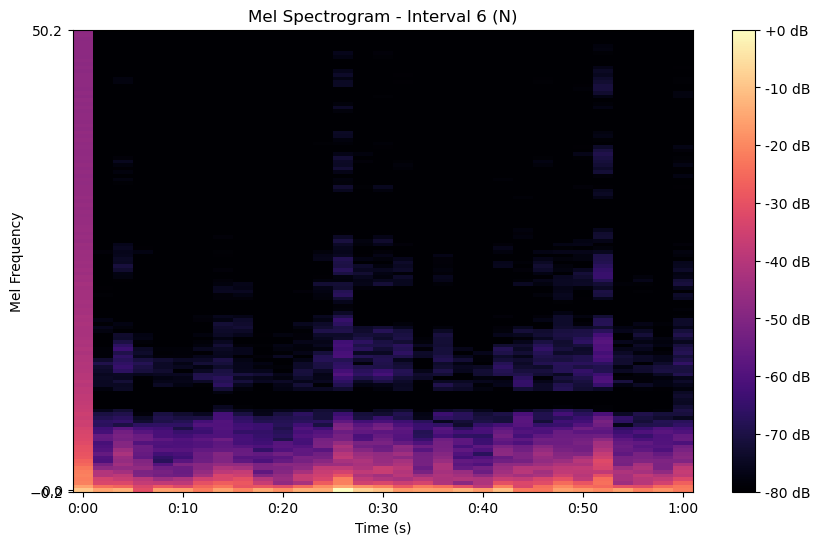

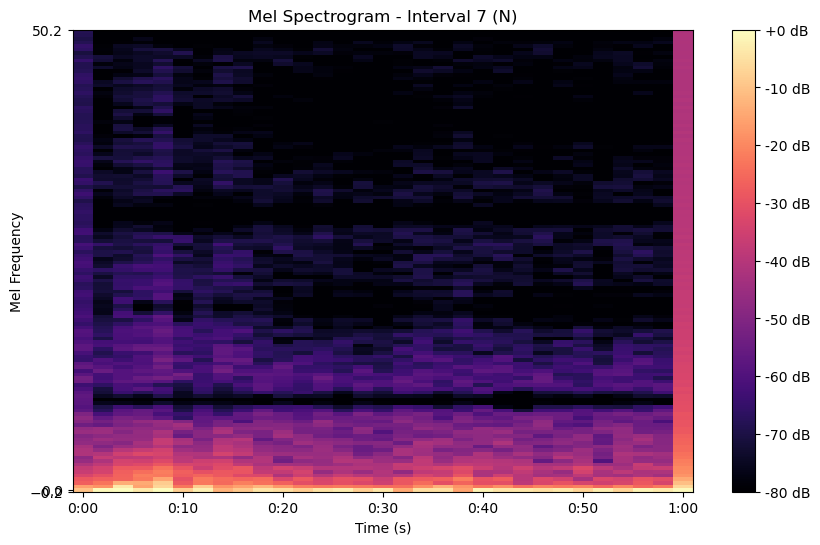

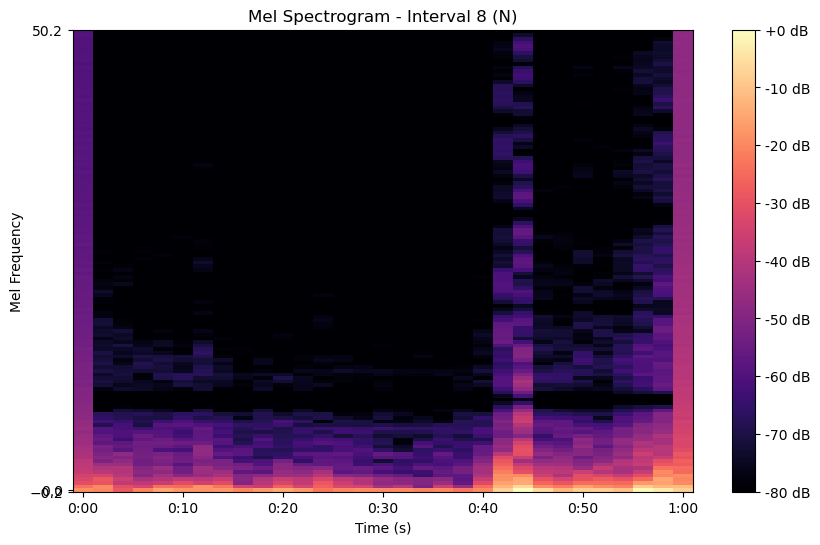

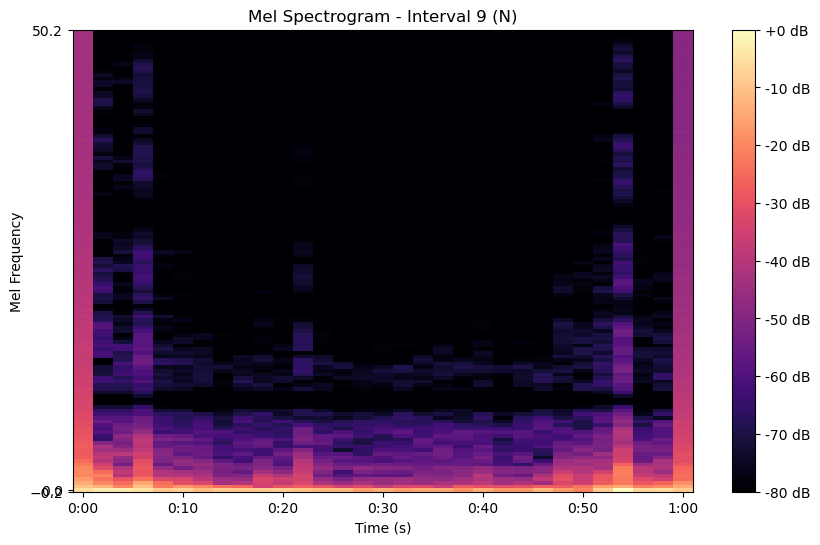

In [93]:
import librosa
import librosa.display

# Define the window size and overlap
window_size = 4 * record.fs
overlap = 2 * record.fs
starting = 0
# Iterate over each interval
for i in range(num_intervals):
    start_index = (i+starting) * record.fs * 60
    end_index = (i +starting+1) * record.fs * 60
    
    # Extract the interval signal
    interval_signal = record.p_signal[start_index:end_index, 0]
    
    # Handle NaN values in the signal
    interval_signal = np.nan_to_num(interval_signal)
    
    # Compute the STFT spectrogram
    stft = librosa.stft(interval_signal, n_fft=window_size, hop_length=overlap)
    
    # Convert STFT to mel spectrogram
    mel_spec = librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=record.fs)
    
    # Convert to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # Plot the mel spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mel_spec_db, sr=record.fs, hop_length=overlap, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency')
    
    # Set the annotation as the title
    annotation_title = annotation.symbol[(i+starting)]
    plt.title(f'Mel Spectrogram - Interval {i+starting} ({annotation_title})')
    
    plt.show()


In [94]:
import os
import numpy as np
import wfdb
from scipy import signal
import librosa
import matplotlib.pyplot as plt

def create_spectrograms():
    # Create the "data/processed" directory if it doesn't exist
    processed_dir = "data/processed"
    if not os.path.exists(processed_dir):
        os.makedirs(processed_dir)

    # Define the patients to load data from
    patients = ['a01r', 'a02r', 'a03r', 'a04r', 'b01r', 'c01', 'c02', 'c03']

    # Create a dictionary to store the spectrograms
    spectrograms = {'STFT': {}, 'Mel': {}, 'LogMel': {}}

    # Iterate over the patients
    for patient in patients:
        # Load the record and annotation
        record = wfdb.rdrecord(f"data/apnea_ecg/{patient}")
        annotation = wfdb.rdann(f"data/apnea_ecg/{patient}", 'apn')

        # Iterate over the 60-second intervals
        interval_length = 60 * record.fs
        for i in range(len(record.p_signal) // interval_length):
            # Extract the interval signal
            start_index = i * interval_length
            end_index = (i + 1) * interval_length
            interval_signal = record.p_signal[start_index:end_index, 0]

            # Handle NaN values and Normalize the interval signal
            interval_signal = np.nan_to_num(interval_signal)
            interval_signal = (interval_signal - np.mean(interval_signal)) / np.std(interval_signal)

            # Compute the STFT spectrogram
            _, _, Zxx = signal.stft(interval_signal, fs=record.fs)
            stft_spec = np.abs(Zxx)

            # Convert STFT to Mel spectrogram
            mel_spec = librosa.feature.melspectrogram(S=stft_spec, sr=record.fs)

            # Convert Mel spectrogram to LogMel spectrogram
            logmel_spec = librosa.power_to_db(mel_spec, ref=np.max)

            # Label for the current interval
            label = annotation.symbol[i] if i < len(annotation.symbol) else "Unknown"

            # Store the spectrograms
            for spec_type, spec_data in zip(['STFT', 'Mel', 'LogMel'], [stft_spec, mel_spec, logmel_spec]):
                if label not in spectrograms[spec_type]:
                    spectrograms[spec_type][label] = []
                spectrograms[spec_type][label].append(spec_data)

    # Save the spectrograms as image files
    for spec_type, labels in spectrograms.items():
        for label, spectrogram_list in labels.items():
            for i, spectrogram in enumerate(spectrogram_list):
                filename = f"{spec_type}_{label}_{i}.png"
                filepath = os.path.join(processed_dir, filename)
                plt.imsave(filepath, spectrogram)

    return "Spectrograms created and stored successfully."

# Call the function to create the spectrograms
create_spectrograms()


C:\Users\hamad\AppData\Local\Temp\ipykernel_40532\3073777779.py:36: RuntimeWarning: invalid value encountered in divide
  interval_signal = (interval_signal - np.mean(interval_signal)) / np.std(interval_signal)
C:\Users\hamad\AppData\Local\Temp\ipykernel_40532\3073777779.py:36: RuntimeWarning: invalid value encountered in divide
  interval_signal = (interval_signal - np.mean(interval_signal)) / np.std(interval_signal)


'Spectrograms created and stored successfully.'

In [95]:
import os
import shutil

def organize_spectrogram_images(source_dir, target_dir):
    """
    Organize spectrogram images into subfolders based on their type and label.
    
    Parameters:
    - source_dir: Directory containing the original spectrogram images.
    - target_dir: Directory where the organized images will be stored.
    """
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for filename in os.listdir(source_dir):
        if filename.endswith('.png'):
            # Extract spectrogram type and label from the filename
            spec_type, label, _ = filename.split('_')

            # Create a subdirectory for the spectrogram type if it doesn't exist
            spec_type_dir = os.path.join(target_dir, spec_type)
            if not os.path.exists(spec_type_dir):
                os.makedirs(spec_type_dir)

            # Create a subdirectory for the label within the spectrogram type directory
            label_dir = os.path.join(spec_type_dir, label)
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)

            # Move the file to the appropriate subdirectory
            src_file = os.path.join(source_dir, filename)
            dest_file = os.path.join(label_dir, filename)
            shutil.move(src_file, dest_file)

    print("Spectrogram images organized successfully.")

# Example usage
source_directory = "data/processed"
target_directory = "data/organized_spectrograms"
organize_spectrogram_images(source_directory, target_directory)


Spectrogram images organized successfully.
